<h1>Time Series Forecasting</h1><br>
Having finished the stages of data acquisition from internal/external data, and once performed the necessary data cleaning step, all is set up to start using these datasets to build a model for Time Series Forecasting

In [150]:
import os, pickle, sys, yaml
import pandas as pd
import numpy as np
import plotly.express as px
from pycaret.regression import *
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import load_workbook, Workbook
#These two libraries are from a specific project
import src.paychex_ml.data_loader as dl
import src.paychex_ml.models as models

warnings.filterwarnings("ignore")
## Change the project path
proyect_path = "C:/Users/(name)/Revenue_forecast"
sys.path.append(proyect_path)

Depending on the project, there must be set the values to be used in the model, particularly the date interval for the study.

In [4]:
# ------------------------------------------------------------------------------------- #
# This is where we change parameters to the model
# ------------------------------------------------------------------------------------- #
train_start_dt = '20140601'
train_end_dt = '20200501'
test_start_dt = '20200601'
test_end_dt = '20210501'
pred_start_dt = '20210601'
pred_end_dt = '20220101'
# This variable establishes the model evaluation metric to be used used in the models
ml_criteria = 'MAE'
# This variable represents the rolling window of future values to predict, relative to the Forecast Point.
forecast_window = 8
forecast_type = '2+10'
# This variable is how strong you want the correlation to be in order to be included as a feature
correlation_threshold = 0.5
# This variable is how many features you want to keep in the final model
features_threshold = 10

In [7]:
# Set manually date if is necessary
model_run_date = datetime.today().strftime('%Y%m%d')

#This project provides a set of time series data or variables to perform the analysis
#However, every project will have their own set of time series data, then this list of items can change
with open(proyect_path+"/src/line_items.yml", "r") as stream:
    items_dicctionary = yaml.safe_load(stream)
    
for key in items_dicctionary.keys():
    print (key, '--', items_dicctionary[key][0])

110 -- Total Payroll Revenue.
111 -- Payroll blended products
112 -- W-2 Revenue
113 -- Delivery Revenue
114 -- ASO Allocation
115 -- Other Processing Revenue
116 -- SurePayroll.
117 -- Total international
120 -- Total 401k
121 -- 401K Fee Revenue
122 -- 401K Asset fee & BP Revenue
130 -- Total ASO Revenue
131 -- HR Solutions (PEO)
132 -- ASO Revenue - Oasis
140 -- Total Online Services
141 -- HR Online
142 -- Time & Attendance
150 -- Other Management Solutions
151 -- Total Paychex Advance
152 -- Full Service Unemployment Revenue
153 -- ESR Revenue
154 -- Cafeteria Plans Revenue
155 -- Benetrac
156 -- Emerging Products
100 -- Management Solutions Revenue.
261 -- Total PEO
270 -- Total Insurance Services
271 -- Workers Comp - Payment Services
272 -- Health Benefits
200 -- Total PEO and Insurance Services.
300 -- Service Revenue
381 -- Interest on Funds Held for Clients
400 -- Total Revenue


In [135]:
#Here we pick one Variable to perform the analysis
id = '270'
target_col, has_drivers, level = items_dicctionary[id]
print("Variable to predict: ", target_col)

Variable to predict:  Total Insurance Services


In [136]:
#Other variables to be used later in the model are defined here
ml_col = target_col+' - ML Predicted'
uts_col = target_col+' - UTS Predicted'
plan_col = target_col+' - Plan'
fcst_col = target_col+' - '+forecast_type+' Forecast'
#This variable is used in the library of an specific provider
fcst_cols = [plan_col,fcst_col,ml_col,uts_col]
has_actuals = True
feature_selection = 'ml_features'

Here is loaded the data that was created during the previous steps

In [137]:
file_path = proyect_path+"/data/clean/table_predictable.csv"
drive_path = proyect_path+"/data/clean/table_drivers.csv"
external_path = proyect_path+"/data/external/external_data_fred.csv"
model_path = proyect_path+"/data/models/"+model_run_date
if not os.path.exists(model_path):
    os.makedirs(model_path)
    print("Directory created")

In [138]:
#The data is loaded using the time interval specified previously along with the variable of interest
all_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path, level=level)
all_df = all_df[['Calendar Date', target_col]]

if has_drivers:
    driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, drive_path)
    #driv_df.drop(columns=['Scenario'], inplace=True)
    all_df = pd.merge(all_df, driv_df, on='Calendar Date', how='inner')
    
#The external dataset is merged with the original dataset using a common column
#This step can vary depending mostly on the type and characteristics of the external data
ext_df = pd.read_csv(external_path, dtype={'date': str})\
    .rename(columns={'date': 'Calendar Date'})
all_df = pd.merge(all_df, ext_df, on='Calendar Date', how='inner')

In [141]:
#This is a common step to split the data in different sets for the model to work with each of them
train_df, test_df, comb_df = models.train_test_combine_split(all_df, train_end_dt, test_start_dt, test_end_dt)

Shape of the training dataframe:  (72, 112)
Shape of the testing dataframe:  (12, 112)
Shape of the combination dataframe:  (84, 112)


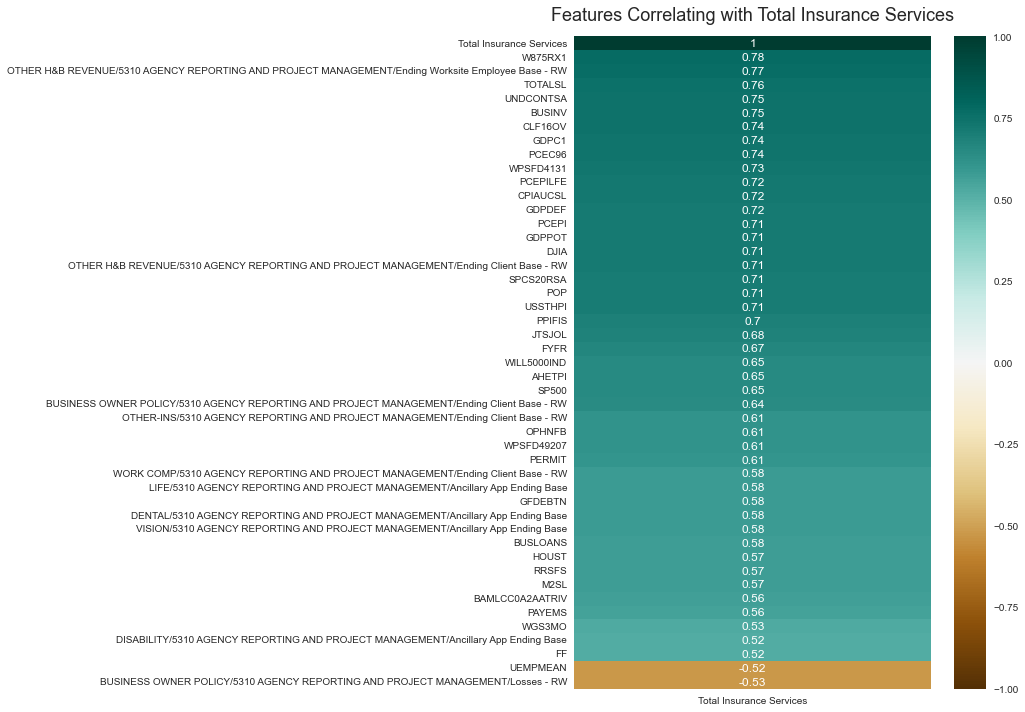

In [143]:
feature_cols = comb_df.columns.to_list()
feature_cols.remove('Calendar Date')
feature_cols.remove(target_col)

#A correlation map is created to portrait the weakest and strongest relations the variable has against the existing features 
corr_feature_cols, fig = models.features_correlation(comb_df, target_col, correlation_threshold)

In [144]:
# run auto ml and get the most important features
best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,1313917.1280,3625403111117.1519,1832751.7190,-0.2429,0.1209,0.0857,0.1367
et,Extra Trees Regressor,1313972.5352,3125839733370.4429,1750584.5213,-0.1734,0.1152,0.0859,0.0900
gbr,Gradient Boosting Regressor,1452899.5633,4122681134652.4375,1958866.6762,-0.4065,0.1310,0.0949,0.0400
ada,AdaBoost Regressor,1495099.6909,4585129085473.0127,2062635.1363,-0.5419,0.1362,0.0958,0.0500
xgboost,Extreme Gradient Boosting,1905122.3750,5642429399040.0000,2350062.4583,-1.0651,0.1555,0.1272,0.1200
lightgbm,Light Gradient Boosting Machine,1947105.2501,6794666580681.8877,2448446.8130,-1.1786,0.1686,0.1271,0.0167
dt,Decision Tree Regressor,1995219.9444,7563925141198.1299,2701011.2324,-1.7198,0.1837,0.1276,0.0167
knn,K Neighbors Regressor,1995747.8750,6856788585130.6670,2547228.3750,-1.3621,0.1769,0.1304,0.0167
huber,Huber Regressor,2043485.6742,7910787860218.3740,2804971.0430,-2.0167,0.1904,0.1375,0.0267
ridge,Ridge Regression,2161745.1667,15097206581930.6660,3571765.0000,-6.4013,0.2095,0.1465,0.0100


<class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [ ]:
#This step defines what features to be used: machine learning or correlation features
if feature_selection == 'ml_features':
    ml_features = models.get_important_features('xgboost', features_threshold)
    feature_cols = ml_features['Feature'].tolist()
elif feature_selection == 'corr_features':
    feature_cols = corr_feature_cols
else:
    print("No feature selection. This could take a while!")

# ml_features = models.get_important_features('xgboost', features_threshold)
# ml_feature_cols = ml_features['Feature'].tolist()

#Next step is created to plot Feature Importance
if len(ml_features.index) != 0:
    # plot the most important features
    fig = px.bar(ml_features.sort_values('Variable Importance', ascending=True),
                 x='Variable Importance',
                 y='Feature',
                 orientation='h',
                 title='Feature Importance Plot')
    fig.show()

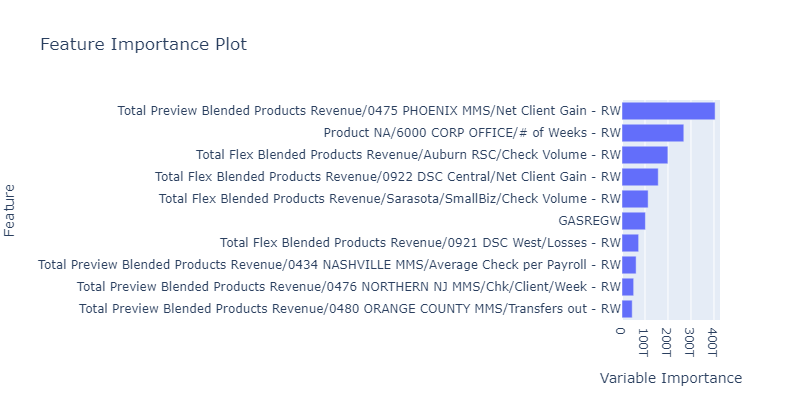

<h3>Modeling and Evaluation</h3>This is a core step as it consists of the application of diverse statistical and artificial intelligence techniques and the evaluation of all the models we identified as the best to produce and accurate outcome.

In [148]:
with open(model_path + '/{}_features.pkl'.format(target_col), "wb") as fp:   #Pickling
    pickle.dump(feature_cols, fp)

# ------------------------------------------------------------------------------------- #
# re-run the auto ml with only the important features
# ------------------------------------------------------------------------------------- #

# Here we need to figure out which set of features we want to use
# ml_features or corr_features
#feature_cols = ml_feature_cols
#feature_cols = corr_feature_cols

#feature_cols = ml_feature_cols
#keeps = ['Calendar Date', target_col]+feature_cols
keeps = [target_col]+feature_cols
train_df = train_df[keeps]
test_df = test_df[keeps]
#comb_df = comb_df[keeps]

best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,1030174.8155,2754735252693.1084,1647041.9385,-0.0209,0.1038,0.0658,0.0133
et,Extra Trees Regressor,1219117.5380,3316913039366.7710,1810517.4044,-0.2385,0.1162,0.0796,0.0867
rf,Random Forest Regressor,1241692.2450,3603863027806.9648,1885333.1984,-0.3412,0.1213,0.0798,0.1067
gbr,Gradient Boosting Regressor,1424121.7701,4222243313242.5210,2036110.5922,-0.5488,0.1324,0.0916,0.0300
xgboost,Extreme Gradient Boosting,1481980.0000,3924637428394.6665,1975054.5417,-0.5138,0.1301,0.0969,0.0767
knn,K Neighbors Regressor,1557522.9583,4653962581333.3330,2102220.2500,-0.6144,0.1401,0.1010,0.0133
par,Passive Aggressive Regressor,1630325.9594,6094448751817.0791,2428928.1861,-1.6080,0.1488,0.1066,0.0100
ada,AdaBoost Regressor,1650511.6649,5509550363094.6953,2303954.2175,-0.9764,0.1489,0.1050,0.0400
dt,Decision Tree Regressor,1889992.9815,6992548576613.7217,2499643.2490,-1.2783,0.1653,0.1208,0.0067
lightgbm,Light Gradient Boosting Machine,1930090.0474,6843111085237.4795,2465127.1623,-1.2058,0.1697,0.1258,0.0200


<class 'sklearn.linear_model._bayes.BayesianRidge'>


In [149]:
pipeline, name = save_model(best, model_path + '/{}_model'.format(target_col))

Transformation Pipeline and Model Successfully Saved


<h3>Visualization</h3>Time Series visualization allows to spot trends to track changes over time. Forecasting visualization instead, let us discover the trends that will happen in the future within a given period of time. 

In [ ]:
# ------------------------------------------------------------------------------------- #
# generate and plot predicted values on the original dataset
# ------------------------------------------------------------------------------------- #

predictions = predict_model(best, data=comb_df)
predictions['Date'] = pd.date_range(start=str(train_start_dt), end = str(test_end_dt), freq = 'MS')
predictions.rename(columns={'Label':target_col+' - ML Predicted'}, inplace=True)
fig = px.line(predictions, x='Date', y=[target_col, target_col+' - ML Predicted'], template = 'plotly_white')
fig.show()
#Please note: the label is different, but it is the same concept

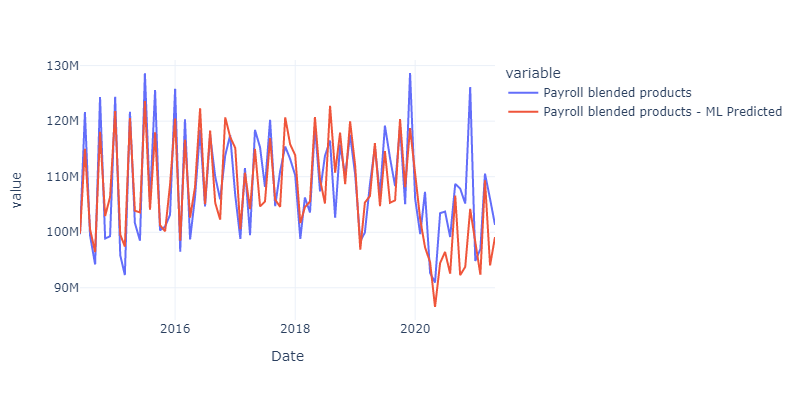

In [26]:
# ------------------------------------------------------------------------------------- #
# This section now applies the trained/tested model to make future predictions
# ------------------------------------------------------------------------------------- #
act_df = all_df[all_df['Calendar Date'] >= pred_start_dt]
act_df = act_df[['Calendar Date', target_col]]
act_df['Calendar Date'] = pd.to_datetime(act_df['Calendar Date'])

# create the future predictions dataframe
if has_actuals:
    pred_df, _ = models.run_auto_arima(comb_df, feature_cols, pred_start_dt, forecast_window, ci=False)
    final_best = finalize_model(best)
    #future_dates = pd.date_range(start = pred_start_dt, end = pred_end_dt, freq = 'MS')
    pred_df = predict_model(final_best, data=pred_df)
    #pred_df = pred_df[['Calendar Date', 'Label']]
    pred_df = pred_df.rename(columns={'Label':ml_col})[['Calendar Date', ml_col]]
    concat_df = pd.merge(act_df, pred_df ,on='Calendar Date', how='inner')
    
    # get plan data
    plan_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path, type='plan', level=level)
    plan_df = plan_df[['Calendar Date', target_col]]
    plan_df.rename(columns={target_col:plan_col}, inplace=True)
    plan_df['Calendar Date'] = pd.to_datetime(plan_df['Calendar Date'])
    concat_df = pd.merge(concat_df,plan_df, on='Calendar Date', how='inner')
    
    # get forecast data
    fcst_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path,
                                type='forecast',
                                forecast_type=forecast_type,
                                level=level)
    fcst_df = fcst_df[['Calendar Date', target_col]]
    fcst_df.rename(columns={target_col:fcst_col}, inplace=True)
    fcst_df['Calendar Date'] = pd.to_datetime(fcst_df['Calendar Date'])
    concat_df = pd.merge(concat_df,fcst_df, on='Calendar Date', how='inner')

############################  Running Auto ARIMA for BUSINV   ############################
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1585.793, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1562.121, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1587.158, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1566.542, Time=0.31 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1571.687, Time=0.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1569.806, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1565.454, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1585.515, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1563.178, Time=0.11 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1584.088, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=1563.526, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 1.867 seconds
############################  End Auto ARIMA for BU

In [27]:
# run UTS
uts_df = comb_df[['Calendar Date', target_col]]
uts_df, uts_model = models.run_auto_arima(uts_df, [target_col], pred_start_dt, forecast_window, ci=True, alpha = 0.05)
uts_df.rename(columns={target_col:uts_col}, inplace=True)

############################  Running Auto ARIMA for Service Revenue   ############################
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2643.294, Time=0.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2669.485, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2650.760, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2641.882, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2653.990, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2639.946, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2648.489, Time=0.10 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2640.752, Time=1.32 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2641.150, Time=1.09 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2639.170, Time=0.43 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=2657.001, Time=0.34 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2640.242, Time=1.03 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=2640.460, 

In [34]:
with open(model_path + '/{}_uts_model.pkl'.format(target_col), 'wb') as pkl:
    pickle.dump(uts_model, pkl)
    
concat_df = pd.merge(concat_df,uts_df, on='Calendar Date', how='inner')

# combine all data together
concat_df = pd.concat([comb_df[['Calendar Date', target_col]],concat_df], axis=0)

# show plot
fig = px.line(concat_df, x='Calendar Date', y=[target_col, ml_col, uts_col, plan_col, fcst_col], template='plotly_white')
fig.show()

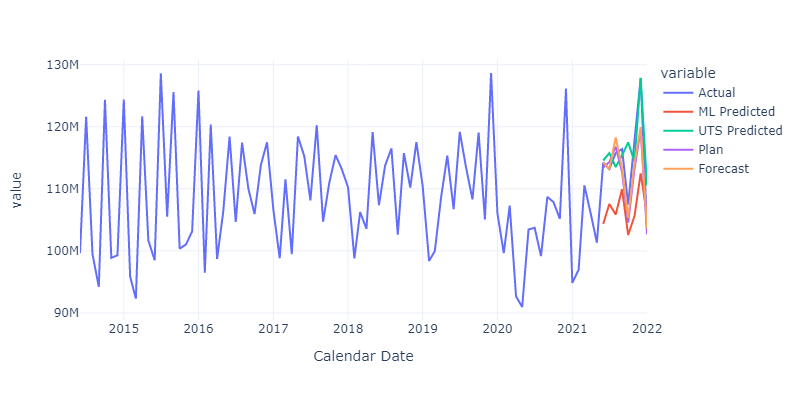

In [39]:
# compute mape_df
#This is a step that belongs to a particular analysis, but can be implemented in studies like this
mape_df = concat_df[['Calendar Date', target_col, ml_col, uts_col, plan_col, fcst_col]]
mape_df = mape_df[mape_df['Calendar Date'] >= datetime.strptime(pred_start_dt, '%Y%m%d')]
mape_df = models.compute_apes_and_mapes(mape_df, 'Calendar Date', target_col, fcst_cols)
mape_df = mape_df.rename(index={True:'MAPE'})
mape_df = pd.concat([mape_df.reset_index(drop=True), uts_df], axis=1)
mape_df

,Calendar Date,Total Revenue,Total Revenue - Plan,Total Revenue - Plan - APE,Total Revenue - 2+10 Forecast,Total Revenue - 2+10 Forecast - APE,Total Revenue - ML Predicted,Total Revenue - ML Predicted - APE,Total Revenue - UTS Predicted,Total Revenue - UTS Predicted - APE,Calendar Date,Total Revenue - UTS Predicted,Lower CI - 95.0%,Upper CI - 95.0%
0,2021-06-01 00:00:00,3.568031e+08,3.548009e+08,0.005612,3.568031e+08,0.000000,3.230795e+08,0.094516,3.399101e+08,0.047346,2021-06-01,3.399101e+08,2.858192e+08,3.940010e+08
1,2021-07-01 00:00:00,3.543810e+08,3.524557e+08,0.005433,3.543810e+08,0.000000,3.234155e+08,0.087379,3.567919e+08,0.006803,2021-07-01,3.567919e+08,2.932189e+08,4.203650e+08
2,2021-08-01 00:00:00,3.560137e+08,3.520724e+08,0.011071,3.602549e+08,0.011913,3.275867e+08,0.079848,3.413132e+08,0.041292,2021-08-01,3.413132e+08,2.694993e+08,4.131272e+08
3,2021-09-01 00:00:00,3.709236e+08,3.567864e+08,0.038113,3.604075e+08,0.028351,3.337098e+08,0.100327,3.560265e+08,0.040162,2021-09-01,3.560265e+08,2.768245e+08,4.352285e+08
4,2021-10-01 00:00:00,3.574400e+08,3.410163e+08,0.045948,3.434113e+08,0.039248,3.405001e+08,0.047392,3.609818e+08,0.009909,2021-10-01,3.609818e+08,2.750245e+08,4.469391e+08
5,2021-11-01 00:00:00,3.646379e+08,3.480824e+08,0.045402,3.520215e+08,0.034600,3.453642e+08,0.052857,3.510391e+08,0.037294,2021-11-01,3.510391e+08,2.588200e+08,4.432583e+08
6,2021-12-01 00:00:00,4.078692e+08,3.752561e+08,0.079960,3.788448e+08,0.071161,3.502673e+08,0.141226,3.833378e+08,0.060145,2021-12-01,3.833378e+08,2.852558e+08,4.814199e+08
7,2022-01-01 00:00:00,4.860343e+08,4.547069e+08,0.064455,4.564271e+08,0.060916,3.544186e+08,0.270795,4.477554e+08,0.078757,2022-01-01,4.477554e+08,3.441418e+08,5.513691e+08
8,NaN,NaN,NaN,0.036999,NaN,0.030774,NaN,0.109293,NaN,0.040214,NaT,NaN,NaN,NaN


In [41]:
#This is the continuation of the previous step
metadata_path = proyect_path + "/data/metadata/"
mape_path = metadata_path + model_run_date + "_mape.xlsx"
if os.path.exists(mape_path):
    book = load_workbook(mape_path)
else:
    book = Workbook()
with pd.ExcelWriter(mape_path, engine = 'openpyxl') as writer:
    writer.book = book
    mape_df.to_excel(writer, sheet_name = target_col[0:30], index=False)

concat_df[concat_df['Calendar Date'] >= pred_start_dt]

,Calendar Date,Total Revenue,Total Revenue - ML Predicted,Total Revenue - Plan,Total Revenue - 2+10 Forecast,Total Revenue - UTS Predicted,Lower CI - 95.0%,Upper CI - 95.0%
0,2021-06-01,3.568031e+08,3.230795e+08,3.548009e+08,3.568031e+08,3.399101e+08,2.858192e+08,3.940010e+08
1,2021-07-01,3.543810e+08,3.234155e+08,3.524557e+08,3.543810e+08,3.567919e+08,2.932189e+08,4.203650e+08
2,2021-08-01,3.560137e+08,3.275867e+08,3.520724e+08,3.602549e+08,3.413132e+08,2.694993e+08,4.131272e+08
3,2021-09-01,3.709236e+08,3.337098e+08,3.567864e+08,3.604075e+08,3.560265e+08,2.768245e+08,4.352285e+08
4,2021-10-01,3.574400e+08,3.405001e+08,3.410163e+08,3.434113e+08,3.609818e+08,2.750245e+08,4.469391e+08
5,2021-11-01,3.646379e+08,3.453642e+08,3.480824e+08,3.520215e+08,3.510391e+08,2.588200e+08,4.432583e+08
6,2021-12-01,4.078692e+08,3.502673e+08,3.752561e+08,3.788448e+08,3.833378e+08,2.852558e+08,4.814199e+08
7,2022-01-01,4.860343e+08,3.544186e+08,4.547069e+08,4.564271e+08,4.477554e+08,3.441418e+08,5.513691e+08


In [42]:
#Creating a new folder to store predictions
predictions_path = proyect_path+"/data/predictions/"+model_run_date
if not os.path.exists(predictions_path):
    os.makedirs(predictions_path)
    print("Directory created")

Directory created


In [45]:
#Creating the dataset to store the predictions
df_write = concat_df.rename(columns={target_col: 'Actual',
                           ml_col: 'ML Predicted',
                           uts_col: 'UTS Predicted',
                           plan_col: 'Plan',
                           fcst_col:' Forecast'})
df_write['Item'] = target_col
df_write

,Calendar Date,Actual,ML Predicted,Plan,Forecast,UTS Predicted,Lower CI - 95.0%,Upper CI - 95.0%,Item
0,2014-06-01,2.074346e+08,NaN,NaN,NaN,NaN,NaN,NaN,Total Revenue
1,2014-07-01,2.483619e+08,NaN,NaN,NaN,NaN,NaN,NaN,Total Revenue
2,2014-08-01,2.110434e+08,NaN,NaN,NaN,NaN,NaN,NaN,Total Revenue
3,2014-09-01,2.064182e+08,NaN,NaN,NaN,NaN,NaN,NaN,Total Revenue
4,2014-10-01,2.584593e+08,NaN,NaN,NaN,NaN,NaN,NaN,Total Revenue
...,...,...,...,...,...,...,...,...,...
3,2021-09-01,3.709236e+08,3.337098e+08,3.567864e+08,3.604075e+08,3.560265e+08,2.768245e+08,4.352285e+08,Total Revenue
4,2021-10-01,3.574400e+08,3.405001e+08,3.410163e+08,3.434113e+08,3.609818e+08,2.750245e+08,4.469391e+08,Total Revenue
5,2021-11-01,3.646379e+08,3.453642e+08,3.480824e+08,3.520215e+08,3.510391e+08,2.588200e+08,4.432583e+08,Total Revenue
6,2021-12-01,4.078692e+08,3.502673e+08,3.752561e+08,3.788448e+08,3.833378e+08,2.852558e+08,4.814199e+08,Total Revenue


In [159]:
#Writing the results to a parquet
df_write.to_parquet(predictions_path+"/"+target_col.replace(" ","")+".parquet")
df = pd.read_parquet("C:/Users/(name)/Revenue_forecast/data/predictions/20220_0_")
df

,Calendar Date,Item,Actual,ML Predicted,UTS Predicted,Plan,Forecast,Lower CI,Upper CI
0,2021-06-01,Delivery Revenue,7.829827e+06,8.742005e+06,7.621582e+06,7.486713e+06,7.829827e+06,5.679662e+06,9.563501e+06
1,2021-07-01,Delivery Revenue,1.243936e+07,1.289055e+07,1.218767e+07,1.261072e+07,1.243936e+07,1.005493e+07,1.432041e+07
2,2021-08-01,Delivery Revenue,7.622602e+06,7.869987e+06,7.427974e+06,7.556542e+06,7.682000e+06,4.843065e+06,1.001288e+07
3,2021-09-01,Delivery Revenue,7.779041e+06,7.976084e+06,7.893044e+06,6.818278e+06,7.149703e+06,5.066063e+06,1.072002e+07
4,2021-10-01,Delivery Revenue,1.126827e+07,1.287066e+07,1.247308e+07,1.174251e+07,1.122409e+07,9.354347e+06,1.559181e+07
5,2021-11-01,Delivery Revenue,7.617424e+06,7.695706e+06,7.406496e+06,6.938894e+06,7.147250e+06,4.056574e+06,1.075642e+07
6,2021-12-01,Delivery Revenue,8.212787e+06,8.042708e+06,8.094190e+06,7.564224e+06,7.716521e+06,4.510080e+06,1.167830e+07
7,2022-01-01,Delivery Revenue,2.243552e+07,2.102415e+07,2.258278e+07,2.262883e+07,2.207458e+07,1.878818e+07,2.637738e+07
8,2021-06-01,Payroll blended products,1.142380e+08,1.069185e+08,1.145630e+08,1.134306e+08,1.142380e+08,9.281367e+07,1.363124e+08
9,2021-07-01,Payroll blended products,1.131859e+08,1.110458e+08,1.157635e+08,1.143207e+08,1.131859e+08,9.176588e+07,1.397611e+08
